In [1]:
# Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [2]:
# Loading data set

housings = pd.read_csv('rent_sao_carlos.csv').drop('Unnamed: 0', axis=1)

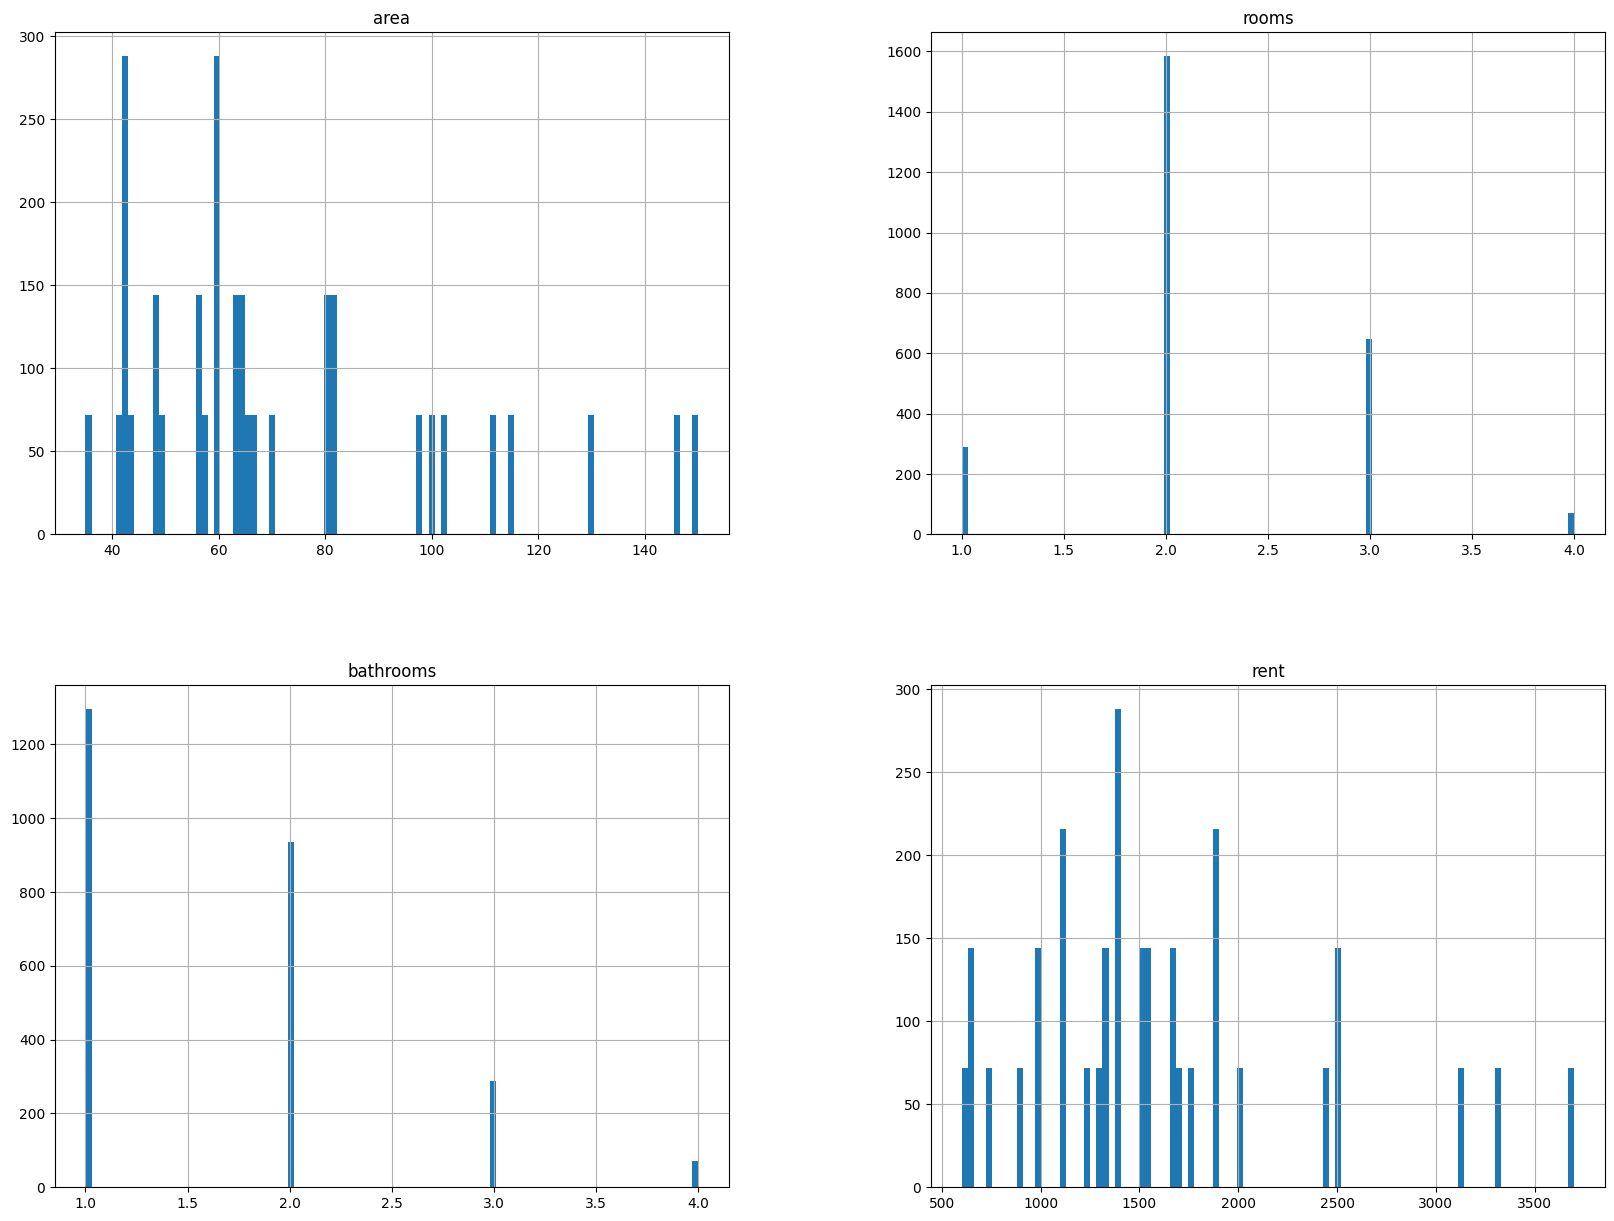

In [3]:
# Getting a first view of the data set

%matplotlib inline
import matplotlib.pyplot as plt
housings.hist(bins=100, figsize=(20,15))
plt.show()

In [4]:
# Get some general information about the dataset

housings.describe()

,area,rooms,bathrooms,rent
count,2592.000000,2592.000000,2592.000000,2592.000000
mean,71.527778,2.194444,1.666667,1605.527778
std,29.330928,0.659228,0.781887,715.686985
min,35.000000,1.000000,1.000000,600.000000
25%,48.750000,2.000000,1.000000,1112.000000
50%,63.000000,2.000000,1.500000,1450.000000
75%,81.250000,3.000000,2.000000,1900.000000
max,150.000000,4.000000,4.000000,3700.000000


In [6]:
# Create a test set and a train set

rs = ShuffleSplit(test_size=0.2, random_state=0)
for train_index, test_index in rs.split(housings):
    train_set = housings.loc[train_index]
    test_set = housings.loc[test_index]

In [7]:
# Looking into correlations between area, rooms, bathrooms and rent

corr_matrix = train_set.corr()
corr_matrix['rent'].sort_values(ascending=False)

rent         1.000000
area         0.688409
rooms        0.558231
bathrooms    0.515409
Name: rent, dtype: float64

array([[<AxesSubplot:xlabel='rent', ylabel='rent'>,
        <AxesSubplot:xlabel='area', ylabel='rent'>,
        <AxesSubplot:xlabel='rooms', ylabel='rent'>,
        <AxesSubplot:xlabel='bathrooms', ylabel='rent'>],
       [<AxesSubplot:xlabel='rent', ylabel='area'>,
        <AxesSubplot:xlabel='area', ylabel='area'>,
        <AxesSubplot:xlabel='rooms', ylabel='area'>,
        <AxesSubplot:xlabel='bathrooms', ylabel='area'>],
       [<AxesSubplot:xlabel='rent', ylabel='rooms'>,
        <AxesSubplot:xlabel='area', ylabel='rooms'>,
        <AxesSubplot:xlabel='rooms', ylabel='rooms'>,
        <AxesSubplot:xlabel='bathrooms', ylabel='rooms'>],
       [<AxesSubplot:xlabel='rent', ylabel='bathrooms'>,
        <AxesSubplot:xlabel='area', ylabel='bathrooms'>,
        <AxesSubplot:xlabel='rooms', ylabel='bathrooms'>,
        <AxesSubplot:xlabel='bathrooms', ylabel='bathrooms'>]],
      dtype=object)

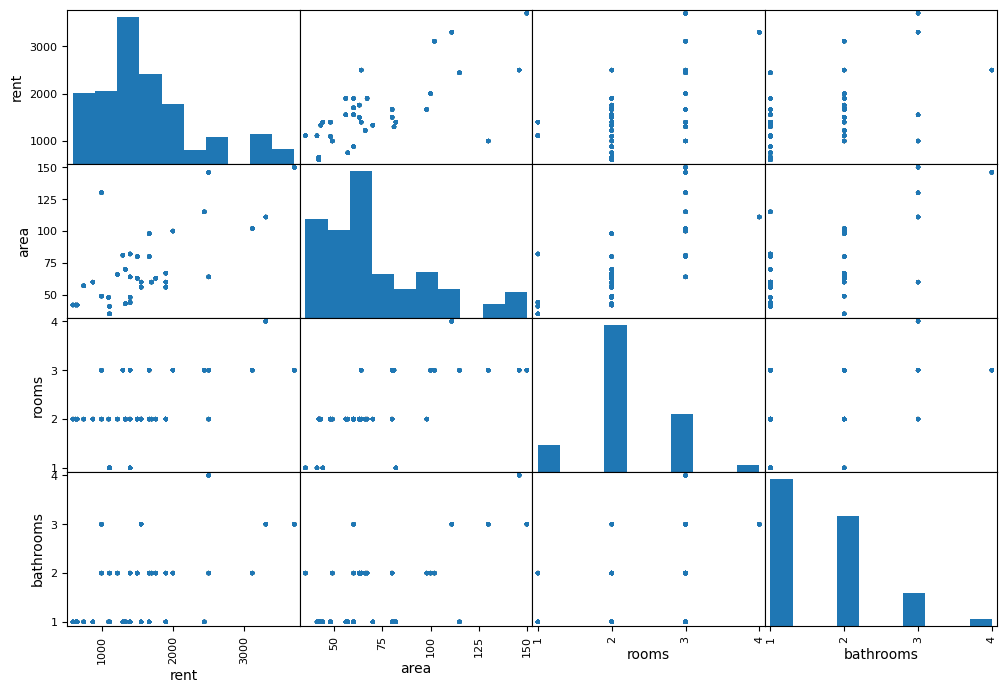

In [8]:
# Looking into the plots, there is only a linear relation between the area and the rent

attributes = ["rent", "area", "rooms",
              "bathrooms"]
pd.plotting.scatter_matrix(train_set[attributes], figsize=(12,8))

In [9]:
# Separating the label from the rest of the data

housings = train_set.drop('rent', axis=1)
labels = train_set['rent'].copy()

In [10]:
# Preparing the data for the training

num_attrs = ['area', 'rooms', 'bathrooms']
cat_attr = ['neighbourhood']
pipeline = ColumnTransformer([
    ('num', StandardScaler(), num_attrs),
    ('cat', OneHotEncoder(), cat_attr),
])
housing_prep = pipeline.fit_transform(housings)

In [11]:
# This function will evaluate the error from an specified training model using the training set

from sklearn.model_selection import cross_val_score

def evaluate_model(model, variables=housing_prep, labels=labels):
    scores = cross_val_score(model, variables, labels,
                            scoring='neg_mean_squared_error', cv=10)
    lin_rmse_scores = np.sqrt(-scores)
    print('Scores:', lin_rmse_scores)
    print('Mean:', lin_rmse_scores.mean())
    print('Std:', lin_rmse_scores.std())

In [12]:
# Below, the training of various regression models

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
evaluate_model(lin_reg)

Scores: [385.86557033 388.84283176 347.02567765 402.43313947 440.83910909
 387.85206338 364.66709306 411.41120602 381.40530977 408.87311444]
Mean: 391.9215114948091
Std: 24.702982677822583


In [13]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
evaluate_model(tree_reg)

Scores: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Mean: 0.0
Std: 0.0


In [14]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()
evaluate_model(forest)

Scores: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Mean: 0.0
Std: 0.0


In [15]:
from sklearn.svm import SVR, NuSVR, LinearSVR

svr = SVR()
evaluate_model(svr)

Scores: [744.20955862 761.91521855 568.07524354 627.33719394 646.77156483
 595.72307594 649.47067654 717.43858607 649.1064898  713.73177239]
Mean: 667.3779380212537
Std: 60.969652948101654


In [16]:
nusvr = NuSVR()
evaluate_model(nusvr)

Scores: [739.01954026 760.07893561 577.95798243 629.21610946 650.03245867
 599.72856783 647.21984078 715.53128071 651.32234214 713.86350815]
Mean: 668.397056603583
Std: 57.60985014926243


In [17]:
linearsvr = LinearSVR()
evaluate_model(linearsvr)

Scores: [669.70823334 681.68515384 568.37171881 626.5564874  646.95690919
 611.25210212 640.3323984  651.33824771 637.59356258 670.75306851]
Mean: 640.4547881911478
Std: 31.4397046488717


In [21]:
# The models that best performed were the decision tree regession and the random forest regression, so I will save them

tree_reg.fit(housing_prep, labels)
forest.fit(housing_prep, labels)

import pickle
from joblib import dump, load
dump(tree_reg, 'tree_reg.pkl')
dump(forest, 'forest.pkl')

['forest.pkl']

In [26]:
# As the decision tree regression is fastest I have choosen it as my model, as the error on the training set was 0, 
# I did not fine tune my model

# When testing on the test set, the final root mean squared error was 0 as well, it seems to be a working model

from sklearn.metrics import mean_squared_error

tree_reg = load('tree_reg.pkl')

x_test = test_set.drop('rent', axis=1)
y_test = test_set['rent'].copy()

x_test_prep = pipeline.transform(x_test)
test_predictions = tree_reg.predict(x_test_prep)
final_mse = mean_squared_error(test_predictions, y_test)
final_rmse = np.sqrt(final_mse)
final_rmse

0.0